In [7]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import random

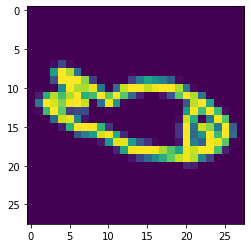

In [8]:
fish_drawings = np.load('data/full_numpy_bitmap_fish.npy').reshape((-1, 28, 28))
plt.imshow(fish_drawings[0], interpolation='nearest')

In [9]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super(VariationalAutoEncoder, self).__init__()
        
        # input image -> encoding
        self.conv1 = nn.Conv2d(1, 8, (3, 3), padding=(1, 1)) # 1x28x28 -> 8x14x14
        self.conv2 = nn.Conv2d(8, 8, (3, 3), padding=(1, 1)) # 8x14x14 -> 8x7x7
        self.conv3 = nn.Conv2d(8, 16, (3, 3), padding=(1, 1)) # 8x7x7 -> 16x3x3
        self.conv4 = nn.Conv2d(16, 32, (3, 3), padding=(1, 1)) # 16x3x3 -> 32x1x1
        
        self.linear1 = nn.Linear(32, 16)
        self.linear2 = nn.Linear(16, 8)
        self.linear3 = nn.Linear(8, 4)
        
        # encoding -> probability distributions
        self.linear_mu = nn.Linear(4, 4)
        self.linear_log_var = nn.Linear(4, 4)
        
        # distribution sample -> decoded image
        self.uplinear1 = nn.Linear(4, 8)
        self.uplinear2 = nn.Linear(8, 16)
        self.uplinear3 = nn.Linear(16, 32)
        
        self.deconv1 = nn.Conv2d(32, 16, (3, 3), padding=(2, 2)) # 1x1x32 -> 4x4x16
        self.deconv2 = nn.Conv2d(16, 8, (3, 3), padding=(2, 2)) # 4x4x16 -> 10x10x8
        self.deconv3 = nn.Conv2d(8, 8, (3, 3), padding=(2, 2)) # 10x10x8 -> 22x22x8
        self.deconv4 = nn.Conv2d(8, 4, (3, 3), padding=(2, 2)) # 22x22x8 -> 24x24x4
        self.deconv5 = nn.Conv2d(4, 4, (3, 3), padding=(2, 2)) # 24x24x4 -> 26x26x4
        self.deconv6 = nn.Conv2d(4, 1, (3, 3), padding=(2, 2)) # 26x26x4 -> 28x28x4
        
        # reconstruction loss function parameters
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
    
    def encode(self, x):
        # make sure it's 2d, that there's one channel, and that it's encoded as batch
        x = torch.reshape(x, (-1, 1, 28, 28))
        
        # reduce with conv & pool; 28x28x1 -> 1x1x32
        x = self.conv1(x)
        x = nn.MaxPool2d((2, 2))(x)
        x = nn.LeakyReLU()(x)
        
        x = self.conv2(x)
        x = nn.MaxPool2d((2, 2))(x)
        x = nn.LeakyReLU()(x)
        
        x = self.conv3(x)
        x = nn.MaxPool2d((2, 2))(x)
        x = nn.LeakyReLU()(x)
        
        x = self.conv4(x)
        x = nn.MaxPool2d((2, 2))(x)
        x = nn.LeakyReLU()(x)
        
        # reduce with fully connected from 2x2x16 (64) -> 16
        x = torch.reshape(x, (-1, 32))
        
        x = self.linear1(x)
        x = nn.LeakyReLU()(x)
        
        x = self.linear2(x)
        x = nn.LeakyReLU()(x)
        
        x = self.linear3(x)
        x = nn.LeakyReLU()(x)
                
        mu = self.linear_mu(x)
        log_var = self.linear_log_var(x)

        return x, mu, log_var
    
    def decode(self, x):        
        x = self.uplinear1(x)
        x = nn.LeakyReLU()(x)
        
        x = self.uplinear2(x)
        x = nn.LeakyReLU()(x)
        
        x = self.uplinear3(x)
        x = nn.LeakyReLU()(x)
        
        x = torch.reshape(x, (-1, 32, 1, 1))
        
        x = nn.Upsample(scale_factor=2)(x)
        x = self.deconv1(x)
        x = nn.LeakyReLU()(x)
           
        x = nn.Upsample(scale_factor=2)(x)
        x = self.deconv2(x)
        x = nn.LeakyReLU()(x)
        
        x = nn.Upsample(scale_factor=2)(x)
        x = self.deconv3(x)
        x = nn.LeakyReLU()(x)
        
        x = self.deconv4(x)
        x = nn.LeakyReLU()(x)
        
        x = self.deconv5(x)
        x = nn.LeakyReLU()(x)
        
        x = self.deconv6(x)
        x = nn.LeakyReLU()(x)
        
        return x.reshape((-1, 28, 28))
        
vae = VariationalAutoEncoder()

In [12]:
def normal_probability(mean, scale, sample):
    normal_dist = torch.distributions.normal.Normal(mean, scale, validate_args=True)
    log_prob = normal_dist.log_prob(sample + 0.1)
    
    return torch.sum(log_prob, dim=(2, 1))

def kl_divergence(mu, var, z):
    # for z, how much less likely is it that it came from mu = 0 and var = 1 than the current mu and var?
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(var))
    q = torch.distributions.Normal(mu, var)
    
    log_prob_qz = q.log_prob(z)
    log_prob_pz = p.log_prob(z)
    
    kl = log_prob_qz - log_prob_pz
    kl = kl.sum(-1)
    return kl
    

def train(model, data):
    epoch_count = 8
    batch_size = 16
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
    for epoch_index in range(epoch_count):
        batch_count = len(data) // batch_size

        
        for batch_index in range(batch_count):
            batch = data[np.random.randint(0, len(data) - 1, (batch_size,))]
            x = torch.from_numpy(batch).float()
            
            _, mu, log_var = vae.encode(x)
            var = torch.exp(log_var / 2)
            
            # create q distribution from our mean and variance that come from a learned relation to encoding
            q = torch.distributions.Normal(mu, var)
            z = q.rsample()
            
            # now decode our distribution sample, z; this should reconstruct the x, so this is x hat
            x_ = vae.decode(z)
            
            # probability of x given x_; found by calculating x pixel probability given x_ as mean and exp(vae.log_scale) as variance
            reconstruction_loss = normal_probability(x_, torch.exp(vae.log_scale), x) 
            
            # q should approach Normal(0, 1)
            kl_divergence_loss = kl_divergence(mu, var, z)
            
            clear_output(wait=True)
            
            loss = (kl_divergence_loss - reconstruction_loss).mean()
                        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print(str(batch_index) + '/' + str(batch_count))
            print('Loss:', loss)
    
train(vae, fish_drawings)

81/8384
Loss: tensor(4311.0454, grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

In [ ]:
def imagine(model, z):     
    y = vae.decode(z).reshape((-1, 28, 28))
       
    plt.imshow(y.detach().numpy().reshape((28,28)), interpolation='nearest')
    
def random_imagination(model):     
    q = torch.distributions.Normal(torch.zeros((1, 4)), torch.ones((1, 4)))
    z = q.sample()

    imagine(model, z)
    
random_imagination(vae)

In [ ]:
from ipywidgets import interact, FloatSlider

def imagine_with_sliders(a,b,c,d):
    print(a,b,c,d)
    imagine(vae, torch.tensor([a,b,c,d]).float())
    
interact(
    imagine_with_sliders,
    a=FloatSlider(min=-2, max=2, step=0.25),
    b=FloatSlider(min=-2, max=2, step=0.25),
    c=FloatSlider(min=-2, max=2, step=0.25),
    d=FloatSlider(min=-2, max=2, step=0.25)
)

In [22]:
import ffmpeg

# got this from: https://github.com/kkroening/ffmpeg-python/issues/246#issuecomment-520200981 🙏
def vidwrite(filename, images, framerate=60, vcodec='libx264'):
    if not isinstance(images, np.ndarray):
        images = np.asarray(images)
    n,height,width,channels = images.shape
    process = (
        ffmpeg
            .input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'.format(width, height))
            .output(filename, pix_fmt='yuv420p', vcodec=vcodec, r=framerate)
            .overwrite_output()
            .run_async(pipe_stdin=True)
    )
    for frame in images:
        process.stdin.write(
            frame
                .astype(np.uint8)
                .tobytes()
        )
    process.stdin.close()
    process.wait()

In [53]:
# make a little wiggling, swimming fish
from time import sleep

def render_animation():
    start = np.array([2, -0.5, 2, -0.5])
    end = np.array([2, -0.5, 1.5, 1])
    
    length = 16
    
    zs = []
    
    for t in range(length):
        progress = (t / (length - 1))
        weighted_start = start * (1 - progress)
        weighted_end = end * progress
        
        zs.append(weighted_start + weighted_end)
    
    ys = []
    
    for z in zs:
        ys.append(vae.decode(torch.from_numpy(z).float()).reshape((28, 28)).detach().numpy())
    
    return ys


frames = np.array(render_animation())

frames = np.stack([frames,frames,frames], axis=3, out=None) # give it 3 channels
frames = np.concatenate([frames, np.flip(frames, axis=0)], axis=0) # make it go back and forward
frames = np.concatenate([frames for _ in range(10)], axis=0)

vidwrite('./vid.mp4', frames, framerate=24)

(16, 28, 28)


In [54]:
def save_model():
    torch.save(vae.state_dict(), './vae_state_dict')
    
#save_model()

In [11]:
def load_model():
    vae.load_state_dict(torch.load('./vae_state_dict'))
    
load_model()